## Kummy DataFrame

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def fetch_product_details(base_link, category_link, product_type_link):
    category_data = []
    
    for category in category_link:
        for product_type in product_type_link:
            category_url = f"{base_link}{category}{product_type}"
            category_page = requests.get(category_url)
            category_soup = BeautifulSoup(category_page.text, "html.parser")
            
            product_links = category_soup.find_all("a", onclick=True)  # Selettore da adattare se necessario
            
            for product_link in product_links:
                product_url = product_link['href']
                product_page = requests.get(product_url)
                product_soup = BeautifulSoup(product_page.text, "html.parser")
                
                product_details = {"category": category, "type": product_type}
                
                title_tag = product_soup.find("p", class_="product-title")
                product_details["name"] = title_tag.text.strip() if title_tag else "N/A"
                
                price_tag = product_soup.find("p", class_="price mt-2")
                product_details["price"] = price_tag.text.strip() if price_tag else "N/A"
                
                dettagli = product_soup.find_all("p", class_="mt-4")
                
                for dettaglio in dettagli:
                    if "Tacco:" in dettaglio.text and "Materiale esterno:" in dettaglio.text and 'Materiale interno:' in dettaglio.text and 'Materiale suola:' in dettaglio.text:
                        descrizione = dettaglio.text.strip()
                        product_details['description'] = descrizione
                
                category_data.append(product_details)
    
    return category_data

base_link = "https://www.kammi.it/"
category_link = ["scarpe-donna/"]
product_type_link = ["sneakers/", "sandali-bassi/", "stivali-stivaletti/", "zeppe/", "sandali-con-tacco/", "scarpe-con-tacco/", "scarpe-basse/"]

product_details = fetch_product_details(base_link, category_link, product_type_link)
kammy_df = pd.DataFrame(product_details)

kammy_df['category'] = kammy_df['category'].str.rstrip('/')
kammy_df['type'] = kammy_df['type'].str.rstrip('/')
kammy_df['price'] = kammy_df['price'].str.replace('€', '').str.replace(',', '.').astype(float)

def separa_descrizione(specifiche):
    dettagli = {}
    parti = specifiche.split('\n')
    for parte in parti:
        chiave_valore = parte.split(':')
        if len(chiave_valore) == 2:
            chiave, valore = chiave_valore
            chiave = chiave.strip()
            valore = valore.strip()
            dettagli[chiave] = valore
    return dettagli

descrizioni_dettagliate = kammy_df['description'].apply(separa_descrizione)
kammy_df['tacco'] = descrizioni_dettagliate.apply(lambda x: x.get('Tacco', 'N/A'))
kammy_df['materiale esterno'] = descrizioni_dettagliate.apply(lambda x: x.get('Materiale esterno', 'N/A'))
kammy_df['materiale interno'] = descrizioni_dettagliate.apply(lambda x: x.get('Materiale interno', 'N/A'))
kammy_df['materiale suola'] = descrizioni_dettagliate.apply(lambda x: x.get('Materiale suola', 'N/A'))
kammy_df = kammy_df.drop(columns=['description'])
kammy_df[['tacco', 'cm']] = kammy_df['tacco'].str.split(expand=True)
kammy_df = kammy_df.reindex(columns=['category','type','name','price','tacco', 'cm','materiale esterno', 'materiale interno', 'materiale suola'])

In [2]:
kammy_df.head()

,category,type,name,price,tacco,cm,materiale esterno,materiale interno,materiale suola
0,scarpe-donna,sneakers,Sneakers 2651 cat,105.0,0,cm,Pelle,Pelle,Gomma
1,scarpe-donna,sneakers,Sneakers 8100,105.0,0,cm,Pelle,Pelle,Gomma
2,scarpe-donna,sneakers,Sneakers 2651 cat,109.0,0,cm,Pelle,Pelle,Sintetico
3,scarpe-donna,sneakers,Sneakers 1717 Piton,109.0,0,cm,Pelle,Pelle,Sintetico
4,scarpe-donna,sneakers,Sneakers 9070,109.0,0,cm,Pelle,Pelle,Sintetico


In [3]:
kammy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   category           105 non-null    object 
 1   type               105 non-null    object 
 2   name               105 non-null    object 
 3   price              105 non-null    float64
 4   tacco              105 non-null    object 
 5   cm                 105 non-null    object 
 6   materiale esterno  105 non-null    object 
 7   materiale interno  105 non-null    object 
 8   materiale suola    105 non-null    object 
dtypes: float64(1), object(8)
memory usage: 7.5+ KB


## Lumberjack DataFrame

In [4]:
# Importazione delle librerie necessarie
from concurrent.futures import ThreadPoolExecutor, as_completed
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Definizione della funzione che effettua la richiesta HTTP alla pagina del prodotto e restituisce il suo contenuto HTML analizzato
def fetch_product_page(session, url):
    try:
        product_page = session.get(url)  # Effettua la richiesta alla pagina del prodotto
        product_soup = BeautifulSoup(product_page.text, "html.parser")  # Analizza il contenuto HTML della pagina del prodotto
        return product_soup
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return None

# Definizione della funzione che estrae i dettagli del prodotto dall'HTML analizzato
def parse_product_details(product_soup):
    if product_soup is None:
        return None

    product_details = {}
    # Estrazione del nome del prodotto
    name_tag = product_soup.find("h1", class_="product__name")
    product_details["name"] = name_tag.text.strip() if name_tag else "N/A"

    # Estrazione del prezzo del prodotto
    price_tag = product_soup.find("span", class_="product__prices-sale")
    product_details["price"] = price_tag.text.strip() if price_tag else "N/A"

    # Estrazione del colore del prodotto
    color_label = product_soup.find("div", class_="detail__properties-label", string=lambda t: "Colore" in t)
    if color_label:
        color_value = color_label.find_next_sibling("div", class_="detail__properties-link")
        product_details["color"] = color_value.text.strip() if color_value else "N/A"

    # Estrazione del materiale del prodotto
    material_label = product_soup.find("div", class_="detail__properties-label", string=lambda t: "Materiale" in t)
    if material_label:
        material_value = material_label.find_next_sibling("div", class_="detail__properties-link")
        product_details["materiale"] = material_value.text.strip() if material_value else "N/A"

    return product_details

# Definizione della funzione principale che raccoglie i dettagli dei prodotti da una lista di link
def fetch_product_details(links, max_workers=5):
    category_data = []

    with requests.Session() as session:  # Utilizza una sessione di requests per riutilizzare le connessioni TCP
        with ThreadPoolExecutor(max_workers=max_workers) as executor:  # Utilizza un ThreadPoolExecutor per effettuare richieste in parallelo
            future_to_url = {}

            for link in links:  # Itera sui link forniti
                page = session.get(link)
                soup = BeautifulSoup(page.text, "html.parser")
                product_divs = soup.find_all("div", class_="product__name")

                for product_div in product_divs:  # Itera sui div che contengono i nomi dei prodotti
                    product_link = product_div.find_parent("a")
                    if product_link and 'href' in product_link.attrs:
                        product_url = "https://www.lumberjack.com" + product_link['href']
                        future = executor.submit(fetch_product_page, session, product_url)  # Sottomette il compito di fetch in parallelo
                        future_to_url[future] = product_url

            for future in as_completed(future_to_url):  # Attende il completamento di tutte le richieste
                product_soup = future.result()  # Ottiene il risultato della richiesta (HTML analizzato)
                product_details = parse_product_details(product_soup)  # Estrae i dettagli del prodotto
                if product_details is not None:
                    category_data.append(product_details)  # Aggiunge i dettagli del prodotto alla lista dei dati

    return category_data

# Lista dei link da cui estrarre i dettagli dei prodotti
links = [
    "https://www.lumberjack.com/it/sport_shoes?gender=man",
    "https://www.lumberjack.com/it/boat-shoes?gender=man",
    "https://www.lumberjack.com/it/slip_on?gender=woman",
    "https://www.lumberjack.com/it/sandals?gender=woman",
    "https://www.lumberjack.com/it/ankle-boots?gender=woman",
    "https://www.lumberjack.com/it/beatles?gender=woman",
    "https://www.lumberjack.com/it/outdoor?gender=woman"
]

# Esegue la funzione principale per ottenere i dettagli dei prodotti e li memorizza in un DataFrame
lumberjack_details = fetch_product_details(links)
lumberjack_df = pd.DataFrame([detail for detail in lumberjack_details if detail is not None])

# Pulizia e formattazione dei dati nel DataFrame
lumberjack_df['price'] = pd.to_numeric(lumberjack_df['price'].astype(str).str.replace(r'\s*EUR', '', regex=True).str.replace(',', '.'), errors='coerce')
lumberjack_df['Category'] = lumberjack_df['name'].apply(lambda x: x.split()[-1])
lumberjack_df['Name'] = lumberjack_df['name'].apply(lambda x: x.split()[0])
lumberjack_df['Type'] = lumberjack_df['name'].apply(lambda x: ' '.join(x.split()[1:-1]) if len(x.split()) > 2 else 'N/A')
lumberjack_df['Category'] = lumberjack_df['Category'].str.title()
lumberjack_df['Name'] = lumberjack_df['Name'].str.title()
lumberjack_df['Type'] = lumberjack_df['Type'].str.title()
lumberjack_df['color'] = lumberjack_df['color'].str.title()
lumberjack_df['materiale'] = lumberjack_df['materiale'].str.title()

# Riorganizza le colonne del DataFrame nell'ordine specificato
lumberjack_df = lumberjack_df[['Category', 'Type', 'Name', 'price', 'color', 'materiale']]

In [5]:
lumberjack_df.head()

,Category,Type,Name,price,color,materiale
0,Uomo,Scarpe Da Barca,Anthony,84.99,Universe Blue,Tumbled Nubuck
1,Uomo,Sneakers,Neil,59.99,Grey,Knitwear -Suede
2,Uomo,Sneaker,Freebound,89.99,White/Navy Blue,Leather
3,Uomo,Sneakers,Marvin,64.99,White,Suede-Synthetic Smooth
4,Uomo,Sneaker,Nolan,89.99,White/Navy Blue,Suede-Canvas


In [6]:
lumberjack_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Category   132 non-null    object 
 1   Type       132 non-null    object 
 2   Name       132 non-null    object 
 3   price      132 non-null    float64
 4   color      132 non-null    object 
 5   materiale  132 non-null    object 
dtypes: float64(1), object(5)
memory usage: 6.3+ KB


## Data PREP: analisi delle scarpe da donna

In [7]:
kammy_df.category.value_counts()

category
scarpe-donna    105
Name: count, dtype: int64

In [8]:
import numpy as np
category = {"scarpe-donna":"Donna"}
kammy_df.category = kammy_df.category.map(category)

In [9]:
kammy_df.head()

,category,type,name,price,tacco,cm,materiale esterno,materiale interno,materiale suola
0,Donna,sneakers,Sneakers 2651 cat,105.0,0,cm,Pelle,Pelle,Gomma
1,Donna,sneakers,Sneakers 8100,105.0,0,cm,Pelle,Pelle,Gomma
2,Donna,sneakers,Sneakers 2651 cat,109.0,0,cm,Pelle,Pelle,Sintetico
3,Donna,sneakers,Sneakers 1717 Piton,109.0,0,cm,Pelle,Pelle,Sintetico
4,Donna,sneakers,Sneakers 9070,109.0,0,cm,Pelle,Pelle,Sintetico


In [10]:
lumberjack_df = lumberjack_df.query("Category == 'Donna'").reset_index(drop=True)

In [11]:
lumberjack_df.head()

,Category,Type,Name,price,color,materiale
0,Donna,Slip On,Agatha,39.99,Navy Blue,Mesh
1,Donna,Slip On,Agatha,39.99,Black,Mesh
2,Donna,Sneaker,Agatha,39.99,Black,Synthetic Smooth
3,Donna,Sneaker,Kendal,39.99,Black,Strass Textile-Nobesto Leather
4,Donna,Sandali,Karol,69.99,Brown,Nubuck


## Analisi: quantità per tipologia

In [12]:
kammy_df.type = kammy_df.type.str.title()
kammy_df.head(10)

,category,type,name,price,tacco,cm,materiale esterno,materiale interno,materiale suola
0,Donna,Sneakers,Sneakers 2651 cat,105.0,0,cm,Pelle,Pelle,Gomma
1,Donna,Sneakers,Sneakers 8100,105.0,0,cm,Pelle,Pelle,Gomma
2,Donna,Sneakers,Sneakers 2651 cat,109.0,0,cm,Pelle,Pelle,Sintetico
3,Donna,Sneakers,Sneakers 1717 Piton,109.0,0,cm,Pelle,Pelle,Sintetico
4,Donna,Sneakers,Sneakers 9070,109.0,0,cm,Pelle,Pelle,Sintetico
5,Donna,Sneakers,Sneakers 82066,95.0,0,cm,Pelle,Pelle,Gomma
6,Donna,Sneakers,Sneakers Rosora,95.0,0,cm,Pelle,Pelle,Gomma
7,Donna,Sneakers,Sneakers 23180,109.0,0,cm,Pelle,Pelle,Sintetico
8,Donna,Sneakers,Sneakers 9147,109.0,0,cm,Pelle,Pelle,Sintetico
9,Donna,Sneakers,Sneakers Rosora,89.9,0,cm,Pelle,Pelle,Sintetico


In [13]:
lumberjack_df.head(10)

,Category,Type,Name,price,color,materiale
0,Donna,Slip On,Agatha,39.99,Navy Blue,Mesh
1,Donna,Slip On,Agatha,39.99,Black,Mesh
2,Donna,Sneaker,Agatha,39.99,Black,Synthetic Smooth
3,Donna,Sneaker,Kendal,39.99,Black,Strass Textile-Nobesto Leather
4,Donna,Sandali,Karol,69.99,Brown,Nubuck
5,Donna,Sandali,Karol,69.99,Brown,Nubuck
6,Donna,Sandali,Jolie,47.99,Cuoio/Platino,Leather-Laminated Leather
7,Donna,Sandali,Jolie,47.99,Black,Nubuck
8,Donna,Sandali,Jolie,47.99,Mid Brown,Nubuck
9,Donna,Sandali,Johanna,69.99,White,Leather


In [14]:
#Verifica delle tipologie di scarpe offerte

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.despine()

<Figure size 640x480 with 0 Axes>

In [16]:
# Tipologie Per Kammy

kammy_type = kammy_df.groupby("type")[["category"]].count()

In [17]:
kammy_type

,category
type,
Sandali-Bassi,15
Sandali-Con-Tacco,15
Scarpe-Basse,15
Scarpe-Con-Tacco,15
Sneakers,15
Stivali-Stivaletti,15
Zeppe,15


In [18]:
# Tipologie Per Lumberjack

lumberjack_type = lumberjack_df.groupby("Type")[["Category"]].count()

In [19]:
lumberjack_type

,Category
Type,
2 Stivaletti,2
Beatles,20
Outdoor,12
Sandali,24
Scarpe Outdoor,2
Scarponcino Outdoor,1
Slip On,2
Sneaker,2
Stivaletti,18


Vi sono delle scarpe con la tipologia simile. Pulisco il dataframe raggruppando alcune tipologie.

In [27]:
import numpy as np
lumberjack_df.Type = (np.where(lumberjack_df.Type == "2 Stivaletti", "Stivaletti",
                              np.where(lumberjack_df.Type == "Stivaletti Beatles", "Stivaletti",
                                      np.where(lumberjack_df.Type == "Scarpe Outdoor", "Outdoor",
                                              np.where(lumberjack_df.Type == "Scarponcino Outdoor", "Outdoor",lumberjack_df.Type ))))
                     )

In [28]:
lumberjack_df.Type.value_counts()

Type
Sandali       24
Stivaletti    21
Beatles       20
Outdoor       15
Slip On        2
Sneaker        2
Name: count, dtype: int64

## Analisi: distribuzione dei prezzi per tipologia

C:\Users\Andrea Bulanti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Andrea Bulanti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Andrea Bulanti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Andrea Bulanti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

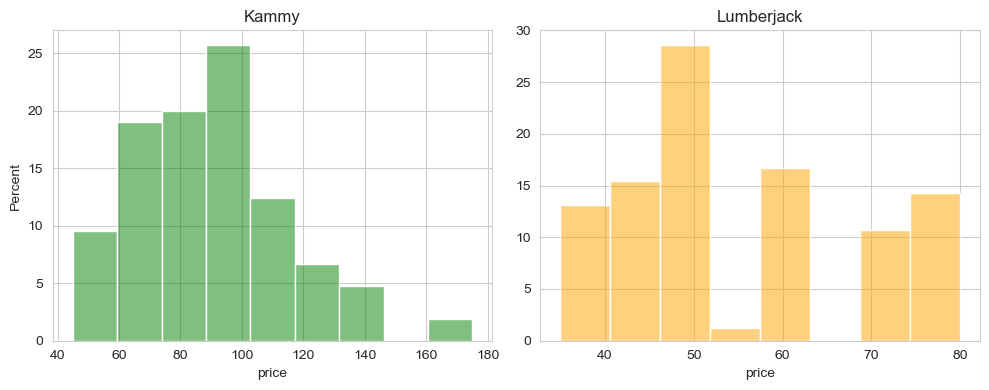

In [47]:
# Affianco le tiplogie di prezzo

fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(10,4))

sns.histplot(data=kammy_df,x="price", stat="percent", color = "green", alpha=0.5, ax=axes[0])

axes[0].set_title('Kammy')

sns.histplot(data=lumberjack_df,x="price", stat="percent", color = "orange", alpha=0.5)

axes[1].set_title('Lumberjack')
axes[1].set_ylabel('')

plt.tight_layout()

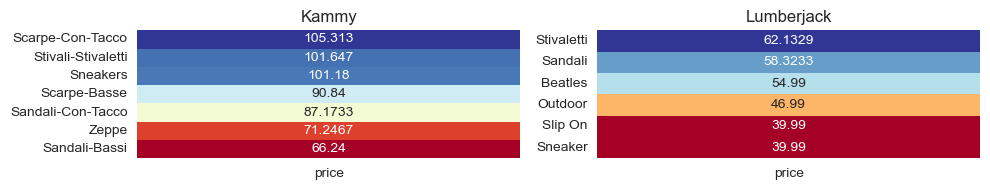

In [42]:
# Affianco le tiplogie di prezzo

fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(10,2))

(sns.heatmap(data=kammy_df.groupby("type")[["price"]].mean().sort_values(by="price", ascending=False)
             , annot=True, cmap='RdYlBu', fmt='g', cbar= False, ax=axes[0])
)

axes[0].set_title('Kammy')
axes[0].set_ylabel('')

(sns.heatmap(data=lumberjack_df.groupby("Type")[["price"]].mean().sort_values(by="price", ascending=False)
             , annot=True, cmap='RdYlBu', fmt='g', cbar= False, ax=axes[1])
)

axes[1].set_title('Lumberjack')
axes[1].set_ylabel('')

plt.tight_layout()

## Analisi del prezzo per materiale

C:\Users\Andrea Bulanti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Andrea Bulanti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Andrea Bulanti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Andrea Bulanti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before ope

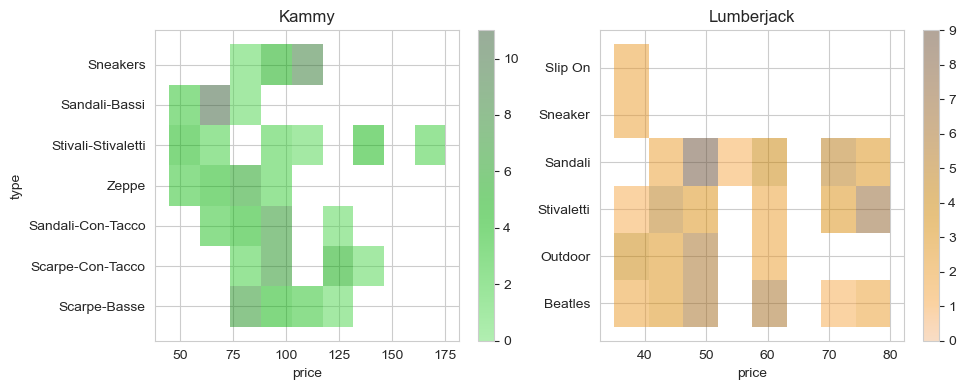

In [49]:
# Affianco le tiplogie di prezzo

fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(10,4))

sns.histplot(data=kammy_df,x="price", y="type", color = "green", alpha=0.5, ax=axes[0], cbar=True)

axes[0].set_title('Kammy')

sns.histplot(data=lumberjack_df,x="price", y="Type", color = "orange", alpha=0.5, ax=axes[1], cbar=True)

axes[1].set_title('Lumberjack')
axes[1].set_ylabel('')

plt.tight_layout()